In [ ]:
!pip install datasets
from datasets import load_dataset

In [ ]:
dataset=load_dataset('go_emotions','simplified')

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Classification methods
from sklearn.naive_bayes import MultinomialNB   # Naive Bayes
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.neural_network import MLPClassifier # Multi-Layer Perceptron
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support

import math
import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout,SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras import optimizers
import random
import copy
import json
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from pprint import pprint
# Text processing libraries
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:
dataset.shape

In [102]:
#We are combining the three dataset and considering them as one to understand the pattern.

df_train=pd.DataFrame(dataset['train'])
df_test=pd.DataFrame(dataset['test'])
df_validation=pd.DataFrame(dataset['validation'])
df_emo=pd.concat([df_train,df_test,df_validation])
print(df_emo.shape)
df_emo.head(5)

(54263, 3)


,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [103]:
df_emo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54263 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    54263 non-null  object
 1   labels  54263 non-null  object
 2   id      54263 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [104]:
#we are removing the square backets in the labels column

df_emo['labels'] = df_emo['labels'].astype(str)
df_emo['labels'] =  df_emo['labels'].apply(lambda x: x.replace('[','').replace(']',''))
df_emo.head(5)

,text,labels,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [ ]:
#we are checking for each sentence how many labels are there.

df_emo['List of classes'] = df_emo['labels'].apply(lambda x: x.split(','))
df_emo['Len of classes'] = df_emo['List of classes'].apply(lambda x: len(x))
print(f"max len of classes: {df_emo['Len of classes'].max()}")

[45446, 8124, 655, 37, 1]


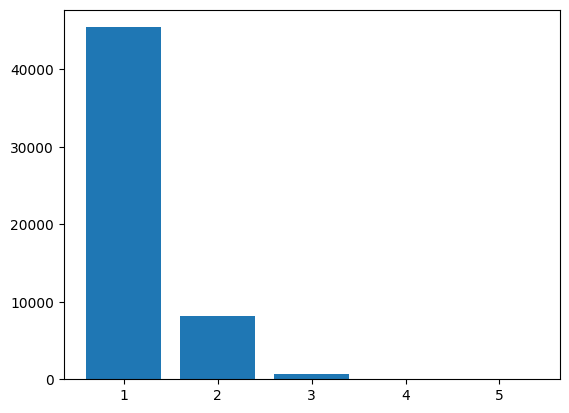

In [26]:
temp_df = df_emo["Len of classes"].value_counts()
print(temp_df.to_list())
plt.bar(x=range(1,6), height=temp_df.to_list());

In [ ]:
#encoding each number with an emotion.

df_emotions = {
    'admiration' : '0',
    'amusement' : '1',
    'anger' : '2',
    'annoyance' : '3',
    'approval' : '4',
    'caring' : '5',
    'confusion' : '6',
    'curiosity' : '7',
    'desire' : '8',
    'disappointment' : '9',
    'disapproval' : '10',
    'disgust' : '11',
    'embarrassment' : '12',
    'excitement' : '13',
    'fear' : '14',
    'gratitude' : '15',
    'grief' : '16',
    'joy' : '17',
    'love' : '18',
    'nervousness' : '19',
    'optimism' : '20',
    'pride' : '21',
    'realization' : '22',
    'relief' : '23',
    'remorse' : '24',
    'sadness' : '25',
    'surprise' : '26',
    'neutral' : '27'
}

df_emotions

In [28]:
df_emotions = {j:i for i, j in df_emotions.items()}
df_emotions

{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

In [29]:
rel_emotions=df_emo.labels.value_counts()[:14].index
df_data=df_emo.loc[df_emo.labels.isin(rel_emotions)]

In [ ]:
df_data.labels.value_counts()

<Axes: >

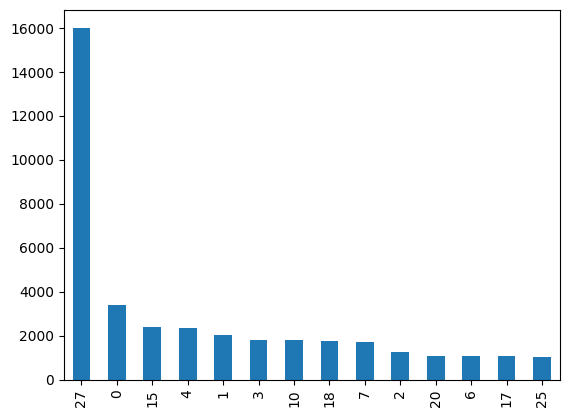

In [31]:
#we are only considering this labels as mentioned in the course work.

df_data['labels'].value_counts().plot(kind='bar')

In [32]:
for i in df_emotions:
    df_emo[df_emotions[i]] = df_emo['List of classes'].apply(lambda x: 1 if i in x else 0)

In [33]:
df_emo.drop(['labels', 'id', 'List of classes', 'Len of classes'], axis=1, inplace =True)

In [ ]:
df_emo

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,It's pretty dangerous when the state decides w...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5422,I filed for divorce this morning. Hoping he mo...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5423,"The last time it happened I just said, ""No"" an...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5424,I can’t stand this arrogant prick he’s no bett...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
df = df_emo[(df_emo["love"]==1) |(df_emo["optimism"]==1) | (df_emo["admiration"]==1) |(df_emo["amusement"]==1) | (df_emo["approval"]==1) |(df_emo["annoyance"]==1) |(df_emo["confusion"]==1) |(df_emo["curiosity"]==1)|(df_emo["joy"]==1) | (df_emo["disapproval"]==1) | (df_emo["gratitude"]==1) | (df_emo["sadness"]==1) | (df_emo["anger"]==1) | (df_emo["neutral"]==1)].loc[:,["text","admiration","amusement","anger","approval","annoyance","confusion","curiosity","disapproval","gratitude","joy","love","optimism", "sadness", "neutral"]]
df.reset_index(drop=True, inplace=True)

In [ ]:
df

{'neutral': 16021, 'admiration': 5122, 'approval': 3269, 'amusement': 2793, 'gratitude': 2681, 'annoyance': 2671, 'curiosity': 2210, 'disapproval': 2117, 'anger': 1936, 'love': 1883, 'confusion': 1543, 'joy': 1250, 'optimism': 1227, 'sadness': 1067}


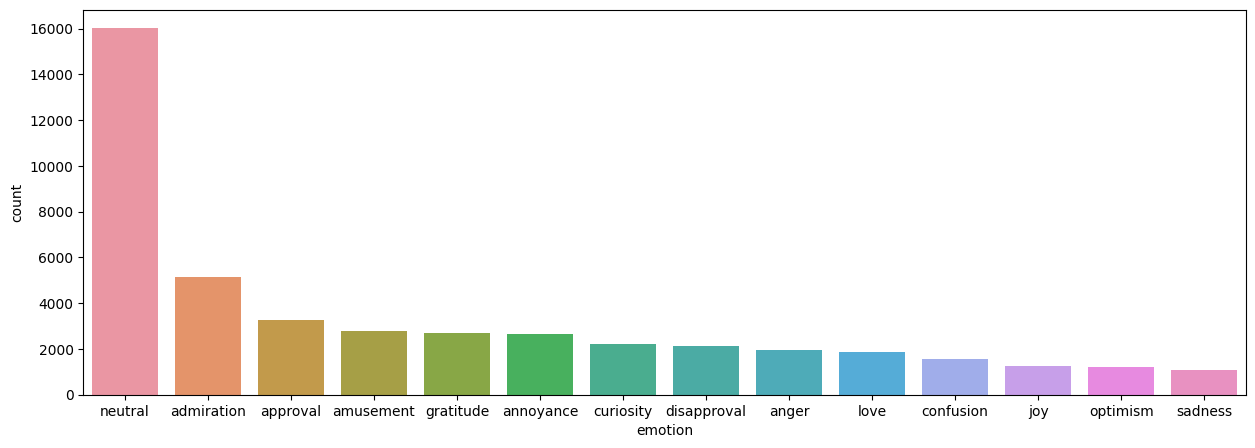

In [36]:
temp_list = df.drop(['text'], axis=1).sum(axis=0).tolist()
counts= dict(zip(["admiration","amusement","anger","approval","annoyance","confusion","curiosity","disapproval","gratitude","joy","love","optimism", "sadness", "neutral"], temp_list))

sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print(sorted_counts)
counts_df = pd.DataFrame(sorted_counts.items(), columns=["emotion", "count"])
plt.subplots(figsize=(15,5))
sns.barplot(data = counts_df, x="emotion", y="count", order=counts_df['emotion']);

In [ ]:
filter_ = (df.drop(['text'], axis=1).sum(axis=1)>1) == True
print(f"sum of values where there is conflict: {filter_.sum()}")
# drop all rows where there is conflict
df.drop(index = df.loc[filter_].index, inplace=True)

In [39]:
labels = ["admiration","amusement","anger","approval","annoyance","confusion","curiosity","disapproval","gratitude","joy","love","optimism", "sadness", "neutral"]
for index, row in df.iterrows():
    df.loc[index,"emotion"] = labels[np.argmax(row.iloc[1:].tolist())]

In [ ]:
df

In [41]:
df_emotion=df

In [ ]:
#we are considering the emotion and text and we are removing the id as it is not relevant for modeling and evaluation part.
df_emotion = df_emotion[["text","emotion"]]
df_emotion

In [43]:
#total numbers of each label in the data set

print(df_emotion['emotion'].value_counts())

neutral        16021
admiration      5122
approval        3269
amusement       2793
gratitude       2681
annoyance       2671
curiosity       2210
disapproval     2117
anger           1936
love            1883
confusion       1543
joy             1250
optimism        1227
sadness         1067
Name: emotion, dtype: int64


In [ ]:
df_emotion.loc[:, 'emotion'] = df_emotion['emotion'].replace({'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'admiration': 4, 'approval': 5, 'amusement': 6, 'gratitude': 7, 'annoyance': 8, 'curiosity': 9, 'disapproval': 10, 'confusion': 11, 'optimism': 12, 'neutral': 13})


df_emotion.head(5)

In [45]:
import re

def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()


  return x

In [ ]:
df_emotion["Clean_text"] = df_emotion["text"].apply(preprocess_corpus)

# Preview of data
display(df_emotion[['text', 'Clean_text']].sample(5))
     

In [47]:
df_emotion = df_emotion[ ['Clean_text'] + [ col for col in df_emotion.columns if col not in ['text', 'Clean_text'] ] ]

# Preview of data   
display(df_emotion.head(3))

,Clean_text,emotion
0,My favourite food is anything I didn t have to...,13
1,Now if he does off himself everyone will think...,13
2,WHY THE FUCK IS BAYLESS ISOING,1


In [ ]:
df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(lambda x: str(x))

df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(nltk.word_tokenize)

lemmatizer = WordNetLemmatizer()

# applying lemmatization to each word in the tokenized text
df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

stemmer = PorterStemmer()

# applying stemming to each word in the tokenized text
df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(lambda x: [stemmer.stem(word) for word in x])

# converting all words to lowercase
df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(lambda x: [word.lower() for word in x])

# applying stopwords and join the words back into sentences
stop_words = stopwords.words('english')
df_emotion['Clean_text'] = df_emotion['Clean_text'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

df_emotion.head()



In [ ]:
df_emotion.info()

In [61]:
#vectorizing the input data.

tfidf = TfidfVectorizer(ngram_range=(1, 1))
X = tfidf.fit_transform(df_emotion['Clean_text'])

In [51]:
#final clean text data after removing the stop words etc.
df_emotion.head(5)

,Clean_text,emotion
0,favourit food anyth cook,13
1,doe everyon think laugh screw peopl instead ac...,13
2,whi fuck bayless iso,1
3,dirti southern wanker,8
4,ye heard abt f bomb ! ha whi thank repli hubbi...,7


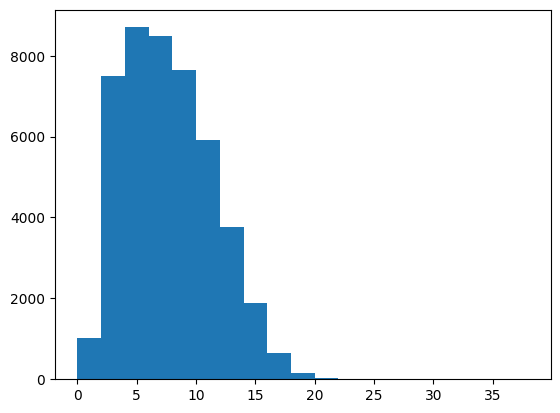

In [54]:
#Max words in the sentence is less then 30 words


plt.hist([ len(nltk.word_tokenize(sentence)) for sentence in df_emotion['Clean_text'].to_list()],bins=range(0,40,2))
plt.show()

In [62]:
#we tested the test with 30 percent and 20 percent .

X_train, X_test, y_train, y_test = train_test_split(X,df_emotion['emotion'], test_size=0.30,random_state=42)


In [63]:
print("X_train ",X_train.shape)

# print the shape of 'x_test'
print("X_test ",X_test.shape)

# print the shape of 'y_train'
print("y_train ",y_train.shape)

# print the shape of 'y_test'
print("y_test ",y_test.shape)

X_train  (32053, 18172)
X_test  (13737, 18172)
y_train  (32053,)
y_test  (13737,)


In [64]:
model = MultinomialNB().fit(X_train, y_train)
predicted = model.predict(X_test)
print("NB:", metrics.accuracy_score(y_test, predicted))


#Evaluating the performance of the model.

confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
precision = metrics.precision_score(y_test, predicted, average='macro')
print(precision)
recall = metrics.recall_score(y_test, predicted, average='macro')
print(recall)
f1 = metrics.f1_score(y_test, predicted, average='macro')
print(f1)

NB: 0.3939724830749072
[[   4    0    0    0   30    2    4    1    0    0    0    0    0  359]
 [   0    8    0    0    0    0    0    4    1    0    0    0    0  526]
 [   0    0   11    0   14    0    1    0    0    0    0    0    0  543]
 [   0    0    0    2    1    0    0    0    0    0    0    0    0  332]
 [   0    0    1    0  405    0    0   13    0    0    0    0    0 1137]
 [   0    0    0    0    8   10    2    2    0    0    0    0    0  971]
 [   0    0    0    0   11    0   38    1    0    0    0    0    0  782]
 [   1    0    0    0   58    0    3  173    0    0    0    0    0  532]
 [   0    0    0    0    0    0    1    2    1    0    0    0    0  813]
 [   0    0    0    0    3    0    1    0    0    3    0    0    0  648]
 [   0    0    1    0    4    0    2    0    0    0    0    0    0  646]
 [   0    0    0    0    0    0    0    1    0    0    0    2    0  447]
 [   0    0    0    0   10    0    0    1    0    0    0    0    1  384]
 [   1    0    0    0   13  

In [65]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.67      0.01      0.02       400
           1       1.00      0.01      0.03       539
           2       0.85      0.02      0.04       569
           3       1.00      0.01      0.01       335
           4       0.73      0.26      0.38      1556
           5       0.67      0.01      0.02       993
           6       0.72      0.05      0.09       832
           7       0.86      0.23      0.36       767
           8       0.50      0.00      0.00       817
           9       1.00      0.00      0.01       655
          10       0.00      0.00      0.00       653
          11       1.00      0.00      0.01       450
          12       1.00      0.00      0.01       396
          13       0.37      1.00      0.54      4775

    accuracy                           0.39     13737
   macro avg       0.74      0.11      0.11     13737
weighted avg       0.61      0.39      0.26     13737



In [66]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

predicted = model.predict(X_test)

print("DecisionTreeClassifier:", metrics.accuracy_score(y_test, predicted))

#Evaluating the performance of the model.

confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
precision = metrics.precision_score(y_test, predicted, average='macro')
print(precision)
recall = metrics.recall_score(y_test, predicted, average='macro')
print(recall)
f1 = metrics.f1_score(y_test, predicted, average='macro')
print(f1)

DecisionTreeClassifier: 0.4896265560165975
[[ 164    0   19    6   49   13   34   13    9   11    3    4    6   69]
 [   5  212    6    9   12   15    2    4   72   10   17   12    7  156]
 [  12    3  363    0   54   20    6    2   12   10    7    4    6   70]
 [   5    4    3  128   12   16    6    3   21   12    5    5    8  107]
 [  39   17   78   10  899   51   35   59   34   31   24   19   22  238]
 [  21   16   26   12   81  178   20   19   36   40   33   22   37  452]
 [  10   10   14    6   47    9  606   10   12   11    9    4    6   78]
 [  17    3    4    1   55   13   17  602    8    4    4    2   15   22]
 [   7   96    9   11   39   51   22    6  140   21   30   21    9  355]
 [   4   13   11   15   53   45    3    4   33   91   25   28    9  321]
 [   3   23   12   22   41   46   15    8   39   22   55   18    7  342]
 [   4   13    8   12   16   33    6    7   27   21   15   61    1  226]
 [  12    2    4    3   24   26    7    8    5    6   15    4  179  101]
 [  57  

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.45      0.41      0.43       400
           1       0.37      0.40      0.39       539
           2       0.59      0.63      0.61       569
           3       0.40      0.37      0.39       335
           4       0.56      0.58      0.57      1556
           5       0.23      0.19      0.21       993
           6       0.68      0.74      0.71       832
           7       0.79      0.77      0.78       767
           8       0.22      0.18      0.20       817
           9       0.20      0.14      0.16       655
          10       0.13      0.08      0.10       653
          11       0.19      0.13      0.15       450
          12       0.50      0.47      0.48       396
          13       0.55      0.64      0.59      4775

    accuracy                           0.49     13737
   macro avg       0.42      0.41      0.41     13737
weighted avg       0.47      0.49      0.48     13737



In [ ]:
#In MLP classifier we test with 40,60 and 100 neurons and also we used activation function relu and tanh.
#for optimization part adam

clf = MLPClassifier(hidden_layer_sizes=(40,), activation='relu', solver='adam', max_iter=100)
clf.fit(X_train, y_train)

# make predictions on testing set
y_pred = clf.predict(X_test)

# evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("F1 score:", f1_score(y_test, y_pred,average='macro'))

Accuracy: 0.41180752711654656
[[  94    5   10    4   56   35   23    9   21   11   14    8   14   96]
 [   3  152    6    5   16   19    1    4   96   28   19    6    6  178]
 [  14   13  234    4   53   34    8    5   16   30   26    8    5  119]
 [   4    5    7   76   11   25    6    5   26   16   21    6    5  122]
 [  37   12   38    5  801   99   24   65   34   43   47   20   20  311]
 [  18   17   11    6   65  200    9   16   49   49   64   48   20  421]
 [  27   11   14    6   43   24  395   13   46   16   31   14    7  185]
 [  19    3    7    3   76   33   11  486   17   21   10   10    9   62]
 [   6   72   10    6   36   35   14    7  142   37   58   24    4  366]
 [   7   22    8   10   31   55   10    5   28   90   40   29    9  311]
 [   6   21   10    5   31   65   13    3   37   44   73   17   10  318]
 [   4    8    7    4   14   27    5    4   31   36   21   54    5  230]
 [   5    7    7    4   34   21    4    5   12   16   18    5  133  125]
 [  53  142   66   52

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           1       0.56      0.47      0.51       400
           2       0.52      0.40      0.45       539
           3       0.63      0.78      0.69       569
           4       0.59      0.39      0.47       335
           5       0.66      0.62      0.64      1556
           6       0.50      0.11      0.18       993
           7       0.73      0.81      0.77       832
           8       0.80      0.84      0.82       767
           9       0.42      0.14      0.21       817
          10       0.64      0.08      0.14       655
          11       0.42      0.02      0.04       653
          12       0.59      0.08      0.13       450
          13       0.66      0.56      0.61       396
          14       0.53      0.88      0.67      4775

    accuracy                           0.58     13737
   macro avg       0.59      0.44      0.45     13737
weighted avg       0.58      0.58      0.53     13737



In [ ]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# predict the labels of test data
predicted = svm_model.predict(X_test)

# evaluate the performance of the model
print("SVM:", metrics.accuracy_score(y_test, predicted))

confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)

precision = metrics.precision_score(y_test, predicted, average='macro')
print(precision)

recall = metrics.recall_score(y_test, predicted, average='macro')
print(recall)

f1 = metrics.f1_score(y_test, predicted, average='macro')
print(f1)

SVM: 0.583824706995705
[[ 187    0   22    2   50    2   37    6    0    0    0    0    6   88]
 [   1  215    6    4    6    3    5    6   58    0    0    0    3  232]
 [   5    3  443    1   32    0    2    1    2    0    0    0    4   76]
 [   3    1    2  131    4    0    7    0    1    0    0    0    6  180]
 [  26   11   90   10  963   12   41   65   11   10    1    1   17  298]
 [  18    4   32    2   70  112   20   16    8    5    3    3   21  679]
 [   9    2   18    2   19    3  672   16    3    1    1    2    7   77]
 [  22    1    4    0   44    4    7  648    0    0    0    0   16   21]
 [   5   66    6    7   23    6   20   11  112    1    4    0    5  551]
 [   8   10   12   10   36   10    3    4    7   53    2    1    5  494]
 [   3   16   12   15   34   12   17    6   13    1   13    3    3  505]
 [   7    9    9    8   12    6    8    7    3    2    1   34    0  344]
 [   6    3    1    2   20    2   10    3    5    0    0    0  222  122]
 [  33   75   50   27  139  

In [86]:
#We tokenizing the text into sequences of integers and padding the sequences 
#with zeros so that they can be used as input to a neural network. 
#The maximum vocabulary size is set to 25000, and the maximum sequence length is set to 48 words.

max_features = 25000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_emotion['Clean_text'].values)
X = tokenizer.texts_to_sequences(df_emotion['Clean_text'].values)
X = pad_sequences(X, maxlen=48) # pad sequences to a fixed length of 100
print(X)

[[   0    0    0 ...  370  120 1274]
 [   0    0    0 ...  338   51  450]
 [   0    0    0 ...   43 5849 5066]
 ...
 [   0    0    0 ...   91  277  856]
 [   0    0    0 ... 2332   39 9343]
 [   0    0    0 ... 1494 1642  846]]


In [87]:
num_classes = 14
y = to_categorical(df_emotion['emotion'].values, num_classes=num_classes)


In [ ]:
#we tested and split the data in combination of 70 -30 and 80 -20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=42)


In [91]:
#we used pre-trained word embeddings from the Google News Word2Vec model
#trainable argument is set to False to ensure that the Word2Vec vectors are not updated during training.

import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

vector_size = 300
embedding_matrix = np.zeros((max_features, vector_size))

for word, index in tokenizer.word_index.items():
    if index >= max_features:
        break
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        embedding_matrix[index] = np.random.normal(scale=0.6, size=(vector_size,))

embedding_layer = Embedding(max_features, vector_size, weights=[embedding_matrix], input_length=X.shape[1], trainable=False)


In [95]:
def createmodel():
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
#we used the batch size of 32 and 64
#we used the epochs of 10 and 20
batch_size=32
model=createmodel()
model.fit(X_train,y_train,epochs=20,batch_size=batch_size,verbose=2)

In [97]:
#evaluating the performance of the model 
#and calculating the loss and accuracy.

model.evaluate(X_test, y_test) 

430/430 [==============================] - 43s 98ms/step - loss: 2.0631 - accuracy: 0.5176


[2.063068389892578, 0.5175802707672119]

In [98]:
y_pred =   np.argmax(model.predict(X_test), axis  =  1)

430/430 [==============================] - 34s 77ms/step


In [99]:
y_true = np.argmax(y_test, axis = 1)

In [100]:
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.37      0.40      0.38       371
           1       0.44      0.41      0.42       590
           2       0.72      0.61      0.66       675
           3       0.46      0.45      0.46       345
           4       0.63      0.61      0.62      1593
           5       0.26      0.25      0.26      1001
           6       0.75      0.72      0.74       867
           7       0.80      0.77      0.78       790
           8       0.17      0.26      0.21       546
           9       0.17      0.25      0.20       438
          10       0.05      0.12      0.07       302
          11       0.15      0.27      0.19       246
          12       0.53      0.55      0.54       383
          13       0.65      0.56      0.60      5590

    accuracy                           0.52     13737
   macro avg       0.44      0.44      0.44     13737
weighted avg       0.56      0.52      0.53     13737

